# DAS vs DTS 
## we took the results from the last step of anomaties detecction 
### we trained a xgboost model to make DTS to DAS prediction

### reading DAS and DTS data then joining them on time and depth keeping only normal data

In [1]:
def DTS_reader(file):
    dts=pd.read_pickle(file)
    dts['time']=pd.to_datetime(dts['time'].apply(lambda x:(x[:-3]+':00')))
    dts['depth']=dts['Depth (m)'].astype(int)
    dts=dts.drop_duplicates(['time','depth']).reset_index()
    dts['class']=dts['class'].apply(lambda x:'normal' if x=='natural' else 'anormal')
    return dts
def DAS_reader(file):
    das=pd.read_pickle(file)
    das=das.drop_duplicates(['time','depth']).reset_index(drop=True)
    das['depth']=das['chanel'].astype(int)
    das['class']=das['class'].apply(lambda x:'normal' if x=='normal' else 'anormal')
    return das
def dataset_creater(das,dts):
    merged=das.merge(dts,on=['time','depth','class'])
    merged=merged[~merged['depth'].isin(merged[merged['class']=='anormal']['depth'].drop_duplicates())].reset_index(drop=True)
    dataset=merged[['time','depth','temperature']]
    dataset['depth']=dataset['depth'].astype('float32')
    dataset['temperature']=dataset['temperature'].astype('float32')
    dataset=pd.concat([dataset, pd.DataFrame(merged['das'].values.tolist()).astype('float32')], axis=1, sort=False)
    dataset=dataset.sort_values(['depth','time'])
    return dataset

In [2]:
import pandas as pd
import datetime
import swifter
from sklearn.preprocessing import MinMaxScaler
dts=DTS_reader('DTS_anomality_output.pkl')
das=DAS_reader('DAS_anomality_output.pkl')
dataset=dataset_creater(das,dts)

<ipython-input-1-533cd0e528e4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['depth']=dataset['depth'].astype('float32')
<ipython-input-1-533cd0e528e4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['temperature']=dataset['temperature'].astype('float32')


## training and predicting 

In [3]:
def trainer_pridicter(dataset):
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    xgbr = xgb.XGBRegressor(verbosity=0) 
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('temperature',axis=1), dataset['temperature'],
                                                        test_size = 0.2,
                                                        random_state=12)
    xgbr.fit(X_train.drop(['time'],axis=1),y_train)
    result=pd.DataFrame(y_test).reset_index(drop=True)
    result.columns=['fact']
    result=pd.concat([result, X_test[['time','depth']].reset_index(drop=True)], axis=1, sort=False).reset_index(drop=True)
    result['predict']=pd.DataFrame(xgbr.predict(X_test.drop(['time'],axis=1)))
    result=result.sort_values(['depth','time']).reset_index(drop=True)
    print('model score :',xgbr.score(X_test.drop(['time'],axis=1),y_test))
    return result


In [4]:
results=trainer_pridicter(dataset)
results

model score : 0.9971342112958091


,fact,time,depth,predict
0,-2.177900,2016-03-18 13:05:00,0.0,1.325272
1,-1.704500,2016-03-18 13:21:00,0.0,-0.460335
2,-1.586000,2016-03-18 13:22:00,0.0,0.772700
3,0.574400,2016-03-18 13:40:00,0.0,0.323910
4,0.693600,2016-03-18 13:41:00,0.0,-0.186683
...,...,...,...,...
23157,108.589996,2016-03-18 18:49:00,371.0,106.455406
23158,106.550003,2016-03-18 18:53:00,371.0,106.890762
23159,106.190002,2016-03-18 18:55:00,371.0,106.063309
23160,106.080002,2016-03-18 18:56:00,371.0,106.431862


## drawing results with L1,L2 metric evaluations

In [11]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab as plot
params = {'legend.fontsize': 26,
          'legend.handlelength': 1,
         'font.size': 28}
plot.rcParams.update(params)
from sklearn.metrics.pairwise import cosine_similarity as  cs ,manhattan_distances as L1,euclidean_distances as L2
import numpy as np
def draw_scores(df,steps=15,fs=5):
    stepit=list(range(0, len(df['depth'].drop_duplicates().values),steps))
    fig, axes = plt.subplots(nrows=int(len(stepit)/3), ncols=3)
    for i in range(len(stepit)):
        tmp=df[df.depth==df['depth'].drop_duplicates().values[stepit[i]]].copy().reset_index()
        try:
            tmp[['fact','predict']].plot(ax=axes.flatten()[i],figsize=(55,90))
            handles, labels = axes.flatten()[i].get_legend_handles_labels()
            handles.append(mpatches.Patch(color='none', label='depth='+str(tmp['depth'][0])))
            fct=tmp['fact'].values.reshape(1, -1)
            prd=tmp['predict'].values.reshape(1, -1)
            text='L1='+str(1-(L1(fct,prd)[0][0])/len(tmp['fact']))[:fs]+'\nL2='+str(1-(L2(fct,prd)[0][0])/len(tmp['fact']))[:fs]
            axes.flatten()[i].text(0.6,0.01,text,transform=axes.flatten()[i].transAxes, bbox=dict(facecolor='none',edgecolor='black',boxstyle='square')) 
            axes.flatten()[i].legend(handles=handles)
        except:
            -1
    return plt.show()

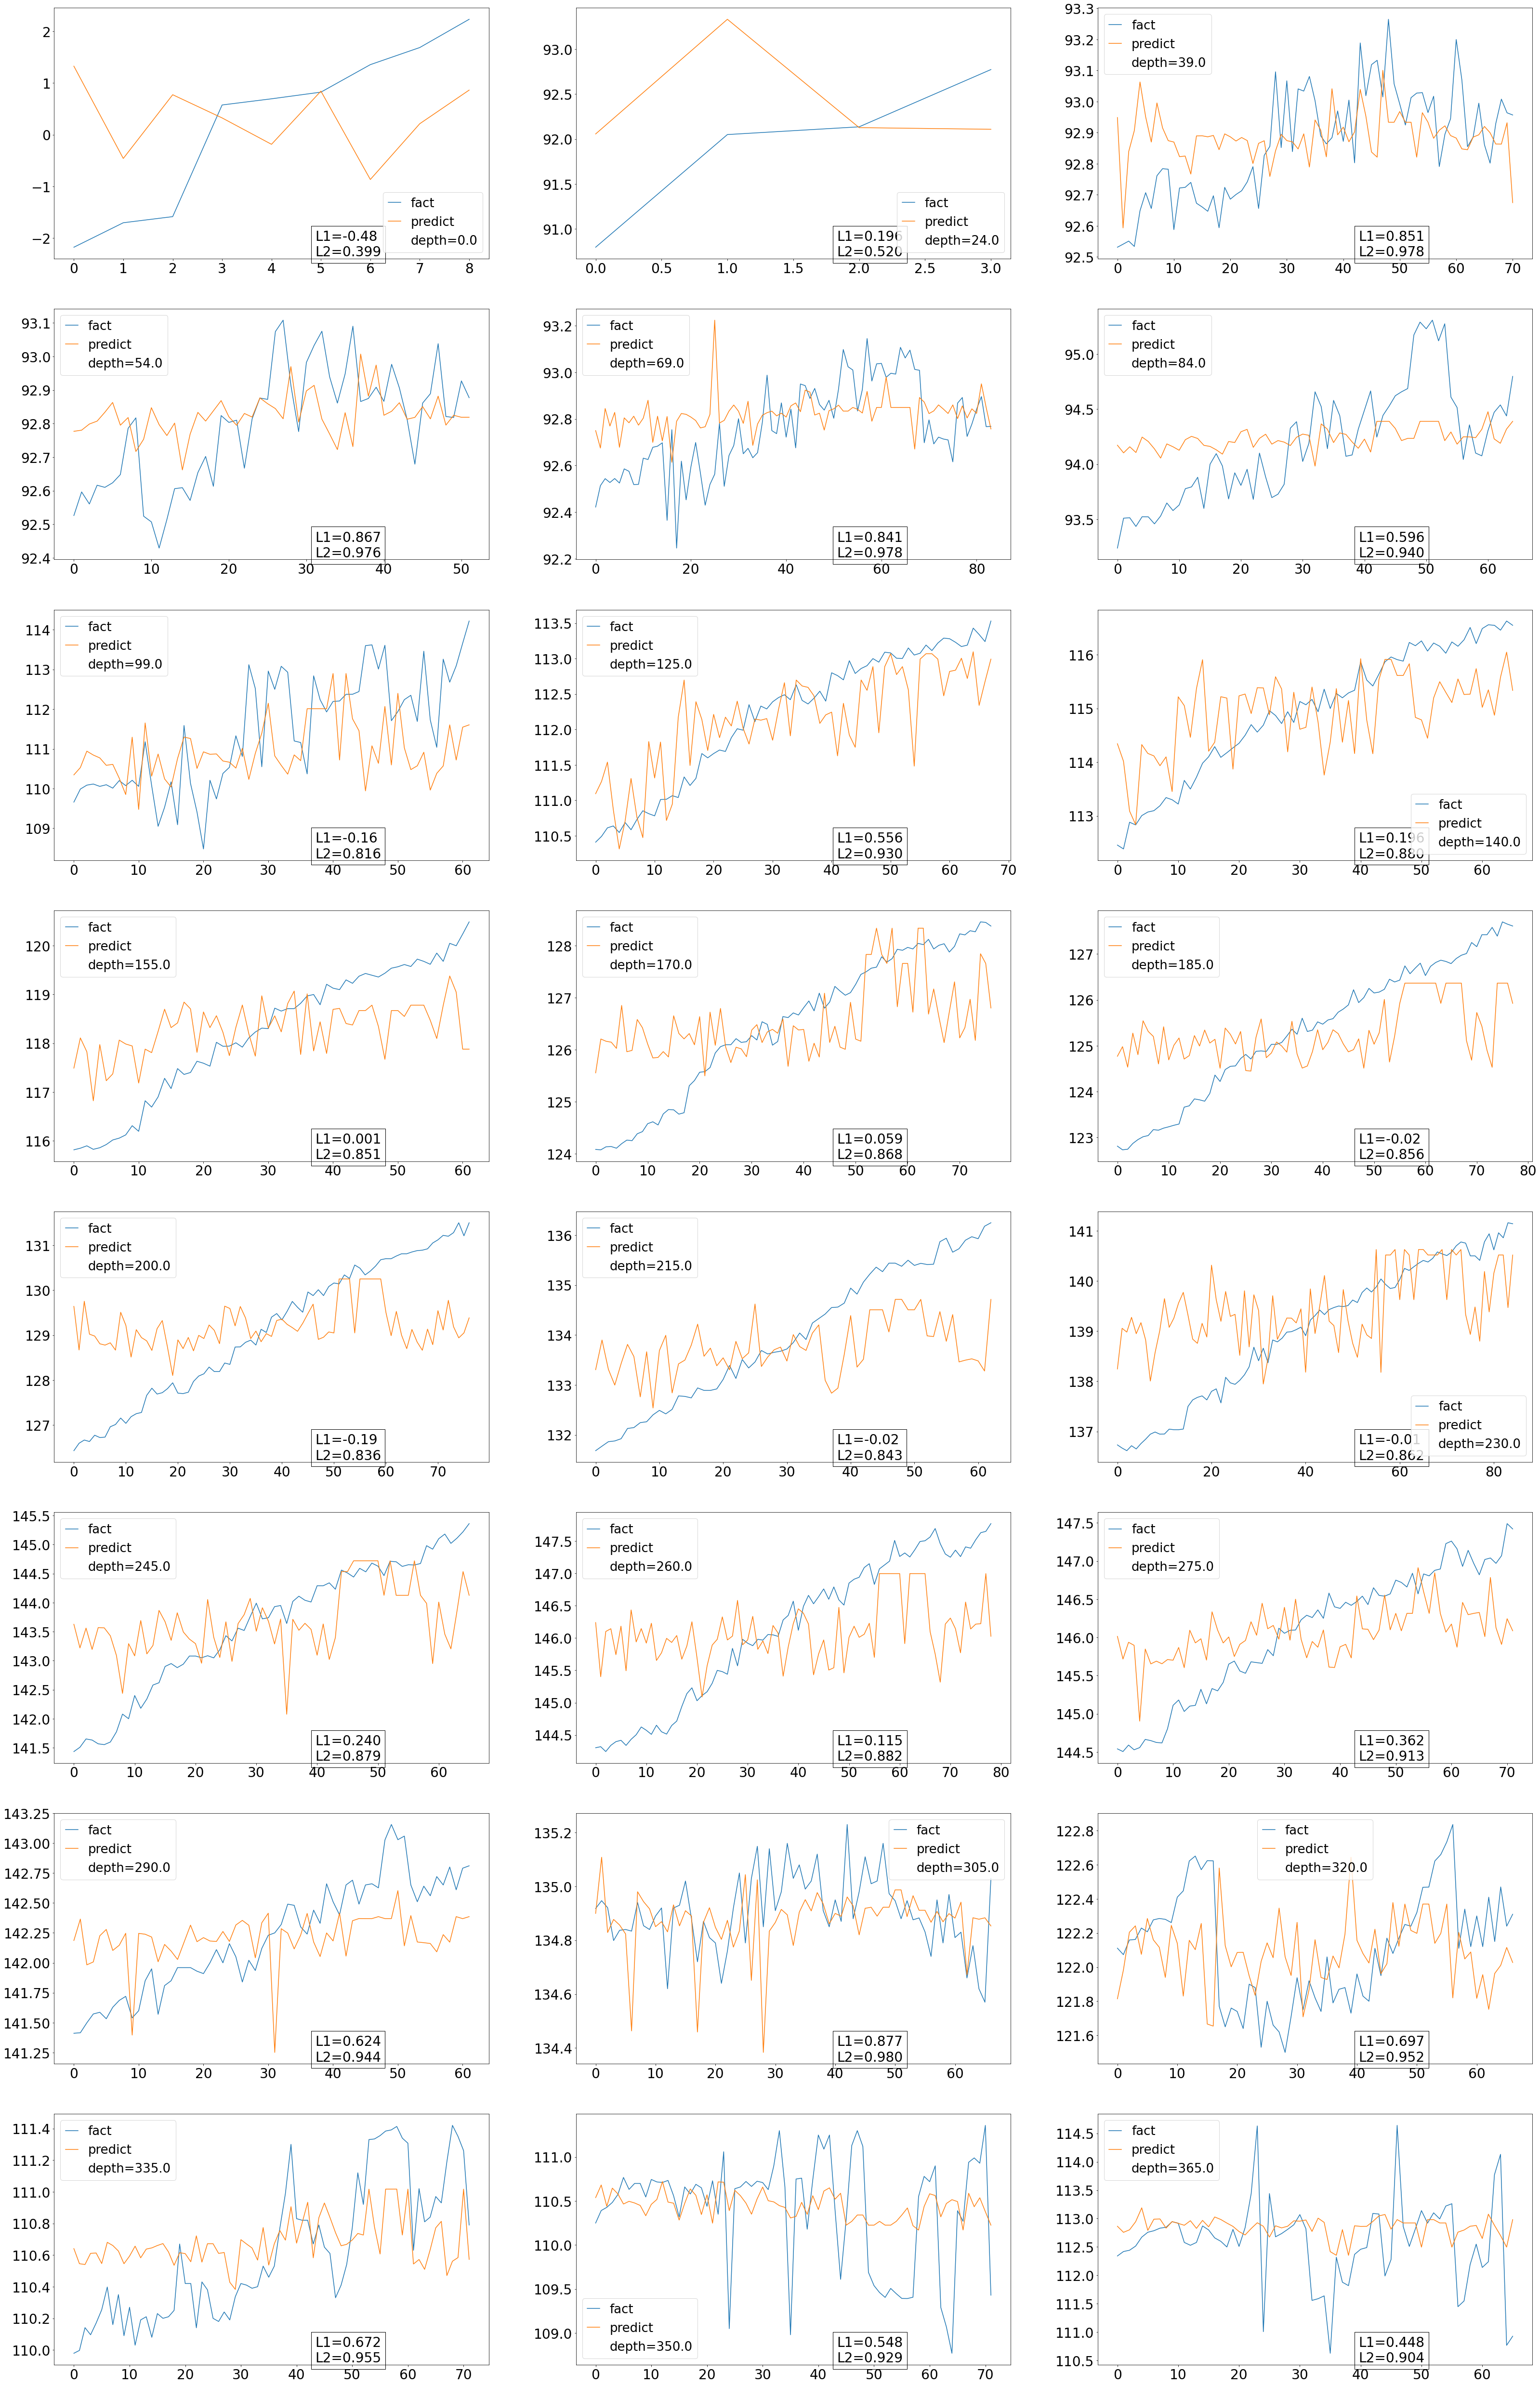

In [12]:
draw_scores(results)